In [1]:
import os, sys, datetime, numpy as np, matplotlib.pyplot as plt
from tqdm.auto import tqdm

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
print(f"Current path: {os.getcwd()}")
sys.path.append('./')

from environments.complementary import ComplementaryPricingEnvironment
from agents.pricing.catalog import CatalogPricingAgent

Current path: /Users/marcomussi/git/PricingComplementaryProducts


In [2]:
horizon = 10000
n_products = 3
n_actions = 5
n_baskets = 1000
products_probs = np.array([0.5, 0.5, 0.5])
alpha = 1.0 # 1 revenue, 0 profit
mc_ep = 1000
num_trials = 5
kernel_L = 1000
dateformat = "(%Y-%b-%d %Ih%Mm%p)"

margins = np.linspace(0.1, 0.9, n_actions)
margins_to_idx = {margins[i]: i for i in range(n_actions)}
margins = margins.reshape(1, n_actions)
margins_env = np.repeat(margins, n_products, axis=0)

demands = np.array([[0.7, 0.7, 0.3, 0.2, 0.1], [0.7, 0.6, 0.6, 0.4, 0.1], [0.7, 0.6, 0.6, 0.5, 0.3]])
demands_compl = np.repeat(demands, 2, axis=1).reshape(n_products, n_actions, 2)
demands_compl[1, :, 1] = np.array([0.95, 0.9, 0.7, 0.6, 0.4]) # enhanced demand for product 1
demands_compl[2, :, 1] = np.array([0.95, 0.9, 0.7, 0.6, 0.4]) # enhanced demand for product 2

In [3]:
# graph_dict = {0: [], 1: [], 2: []} # product 0, 1, 2 are all leaders/independent
graph_dict = {0: [1, 2]} # product 0 is leader of products 1 and 2
env = ComplementaryPricingEnvironment(n_products, n_actions, margins_env, demands_compl, n_baskets, 
                                      products_probs, alpha, graph_dict, mc_ep=mc_ep, seed=0)
vals = env.compute_values()
for i in env.leaders_lst:
    print(f"Optimal values for leader {i}:")
    print(np.round(vals[i], 3))

Optimal values for leader 0:
[[0.512 0.914 1.012 0.886 0.514]
 [1.1   1.508 1.46  1.398 1.1  ]
 [0.721 1.123 1.17  1.067 0.719]
 [0.626 1.028 1.1   0.986 0.625]
 [0.514 0.912 1.01  0.886 0.513]]


In [4]:
graph_dict = {0: [1, 2]} # product 0 is leader of products 1 and 2

results_lst = []

for trial_i in range(num_trials):

    env = ComplementaryPricingEnvironment(n_products, n_actions, margins_env, demands_compl, n_baskets, 
                                          products_probs, alpha, graph_dict, mc_ep=mc_ep, seed=trial_i)

    action_vals = env.compute_values()

    results_lst.append({"pseudo_regret" : np.zeros((horizon)), 
                        "actions" : np.zeros((horizon, n_products))})
    
    agent = CatalogPricingAgent(n_products, n_actions, margins_env, alpha, kernel_L, horizon, graph_dict=graph_dict)

    opt = env.compute_best_action_value()

    for t in tqdm(range(horizon)):

        results_lst[-1]["actions"][t, :] = agent.pull()

        res_mx = env.step(results_lst[-1]["actions"][t, :].ravel())

        agent.update(res_mx[:, :, 0], res_mx[:, :, 1])

        results_lst[-1]["pseudo_regret"][t] = opt - env.compute_action_value(results_lst[-1]["actions"][t, :].ravel())
    


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

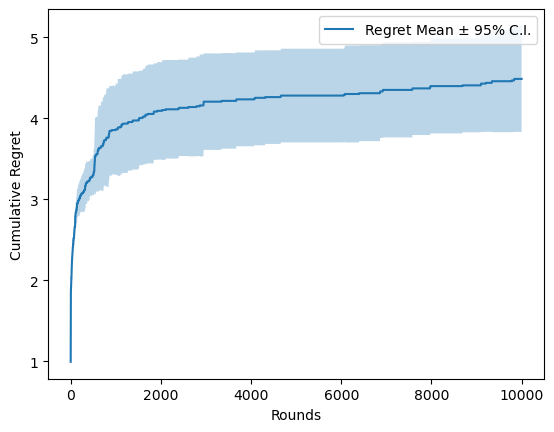

In [5]:
inst_regret_matrix = np.zeros((num_trials, horizon))

for i in range(num_trials):
    inst_regret_matrix[i, :] = np.array(results_lst[i]["pseudo_regret"])
    
cum_regret_matrix = np.cumsum(inst_regret_matrix, axis=1)
results_mean = np.mean(cum_regret_matrix, axis=0)
results_std = 1.96 * np.std(cum_regret_matrix, axis=0) / np.sqrt(num_trials)

x_plt = np.linspace(0, horizon-1, horizon, dtype=int)
plt.plot(x_plt, results_mean[x_plt], label="Regret Mean $\pm$ 95% C.I.")
plt.fill_between(x_plt, results_mean[x_plt] - results_std[x_plt], 
                 results_mean[x_plt] + results_std[x_plt], alpha=0.3)
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regret")
plt.legend()

result_folder = "results"
if not os.path.exists(result_folder):
    os.makedirs(result_folder)
save_path = result_folder + "/compl_run_" + datetime.datetime.now().strftime(dateformat) + ".jpg"
plt.savefig(save_path)